In [1]:
import numpy as np

ACTIONS = ('U', 'D', 'L', 'R') # 할 수 있는 행동 Up, Down, Left, Right
DELTA_THRESHOLD = 1e-3 #수렴 기준(값 변화가 이보다 작아지면 반복 종료)
GAMMA = 0.9 # 할인율(현재 or 미래 보상 중 무엇을 중요하게 생각할지 결정하는 지표)

# 격자 공간의 클래스를 정의
class Grid:
	def __init__(self, rows, cols, start):
		self.rows = rows # 격자의 행
		self.cols = cols # 격자의 열
		self.i = start[0] # 시작 좌표 (i, j)
		self.j = start[1]

	# 각 상태의 보상과 선택 가능한 행동을 설정
	def set(self, rewards, actions):
		self.rewards = rewards # 각 상태의 보상
		self.actions = actions # 각 상태에서 가능한 행동들

	def set_state(self, s):
		self.i = s[0] # 내부 상태(i, j)를 주어진 상태 s로 설정
		self.j = s[1]

	def current_state(self):
		return (self.i, self.j) # 최근 내부 상태를 튜플로 반환

	def is_terminal(self, s):
		return s not in self.actions # 종단 상태인지 확인: 그 상태에 대한 행동이 정의되어 있지 않다면 종단 상태

	def move(self, action):
		if action in self.actions[(self.i, self.j)]:
			if action == 'U':
				self.i -= 1
			elif action == 'D':
				self.i += 1
			elif action == 'R':
				self.j += 1
			elif action == 'L':
				self.j -= 1
	    # 보상이 있을 경우 보상을 반환
		return self.rewards.get((self.i, self.j), 0)

	# 모든 상태를 반환
	def all_states(self):
		return set(self.actions.keys()) | set(self.rewards.keys())

# 격자 공간과 각 상태에서 선택 가능한 행동을 정의
def standard_grid():
	grid = Grid(3, 4, (2, 0))
	rewards = {(0, 3): 1, (1, 3): -1} # (0, 3)은 보상 +1, (1, 3)은 보상 -1
	actions = { # 좌표마다 가능한 행동 정의
		(0, 0): ('D', 'R'),
		(0, 1): ('L', 'R'),
		(0, 2): ('L', 'D', 'R'),
		(1, 0): ('U', 'D'),
		(1, 2): ('U', 'D', 'R'),
		(2, 0): ('U', 'R'),
		(2, 1): ('L', 'R'),
		(2, 2): ('L', 'R', 'U'),
		(2, 3): ('L', 'U'),
	} # (1, 1)은 벽임
	grid.set(rewards, actions)
	return grid

def print_values(V, grid):  # 정책을 평가해서 얻은 가치 함수(V) 출력
	for i in range(grid.rows):# V: 가치 함수 딕셔너리 {상태: 가치}
		print("---------------------------")
		for j in range(grid.cols):
			value = V.get((i, j), 0)
			if value >= 0:
				print("%.2f | " % value, end = "")
			else:
				print("%.2f | " % value, end = "")
		print("")

def print_policy(P, grid): # 정책 출력 종
	for i in range(grid.rows):
		print("---------------------------")
		for j in range(grid.cols):
			action = P.get((i, j), ' ') # P: 정책 딕셔너리 {상태: 행동}(종단 상태는 P에 포함 X 이므로 기본값 ' ')
			print("  %s  |" % action, end = "")
		print("")

# 가치 반복 구현
if __name__ == '__main__':
    # 격자 공간을 초기화
	grid = standard_grid()

	# 보상을 출력
	print("\n보상: ")
	print_values(grid.rewards, grid)

	# 초기 정책은 각 상태에서 선택 가능한 행동을 무작위로 선택
	policy = {}
	for s in grid.actions.keys():
		policy[s] = np.random.choice(ACTIONS)

	# 정책 초기화(무작위)
	print("\n초기 정책:")
	print_policy(policy, grid)

	# 가치 함수 V(s) 초기화
	V = {}
	states = grid.all_states()
	for s in states:
		# V[s] = 0
		if s in grid.actions:
			V[s] = np.random.random()
		else:
			# 종단 상태
			V[s] = 0

	# 수렴할 때까지 반복
	i = 0
	while True:
		maxChange = 0
		# 모든 상태에 대해 업데이트
		for s in states:
			oldValue = V[s]

			# 종단 상태가 아닌 상태에 대해서만 V(s)를 계산
			if s in policy:
				newValue = float('-inf')
				for a in ACTIONS:
					grid.set_state(s)
					r = grid.move(a) # 행동 a 후에 받는 보상
					# 벨만 방정식 계산
					v = r + GAMMA * V[grid.current_state()]
					if v > newValue:
						newValue = v

				# 가치 상태 업데이트
				V[s] = newValue
				maxChange = max(maxChange, np.abs(oldValue - V[s]))

		# 각 반복마다 값 출력
		print("\n%i  번째 반복" % i, end = "\n")
		print_values(V, grid)
		i += 1

		# 수렴 판정
		if maxChange < DELTA_THRESHOLD:
			break

	# 최적 가치 함수를 찾는 정책을 도출
	for s in policy.keys():
		bestAction = None
		bestValue = float('-inf')
		# 가능한 모든 행동에 대해 반복
		for a in ACTIONS:
			grid.set_state(s)
			r = grid.move(a)
			v = r + GAMMA * V[grid.current_state()]
			if v > bestValue:
				bestValue = v
				bestAction = a
		policy[s] = bestAction

	# 계산된 가치 함수와 정책을 출력
	print("\n가치 함수: ")
	print_values(V, grid)

	print("\n정책: ")
	print_policy(policy, grid)


보상: 
---------------------------
0.00 | 0.00 | 0.00 | 1.00 | 
---------------------------
0.00 | 0.00 | 0.00 | -1.00 | 
---------------------------
0.00 | 0.00 | 0.00 | 0.00 | 

초기 정책:
---------------------------
  U  |  R  |  R  |     |
---------------------------
  L  |     |  R  |     |
---------------------------
  R  |  D  |  D  |  D  |

0  번째 반복
---------------------------
0.82 | 0.82 | 1.00 | 0.00 | 
---------------------------
0.74 | 0.00 | 0.73 | 0.00 | 
---------------------------
0.53 | 0.53 | 0.66 | 0.53 | 

1  번째 반복
---------------------------
0.81 | 0.90 | 1.00 | 0.00 | 
---------------------------
0.73 | 0.00 | 0.90 | 0.00 | 
---------------------------
0.66 | 0.59 | 0.81 | 0.59 | 

2  번째 반복
---------------------------
0.81 | 0.90 | 1.00 | 0.00 | 
---------------------------
0.73 | 0.00 | 0.90 | 0.00 | 
---------------------------
0.66 | 0.73 | 0.81 | 0.73 | 

3  번째 반복
---------------------------
0.81 | 0.90 | 1.00 | 0.00 | 
---------------------------
0.73 | 0.00 | 0.9

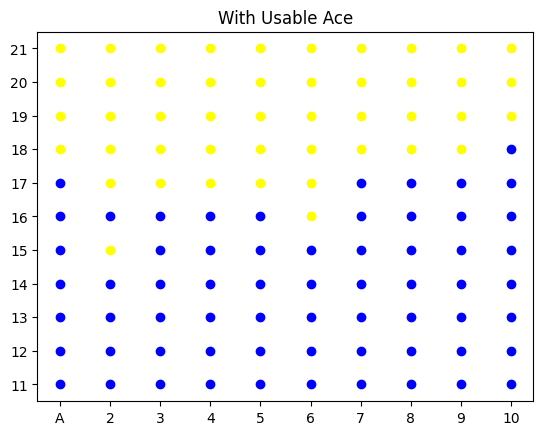

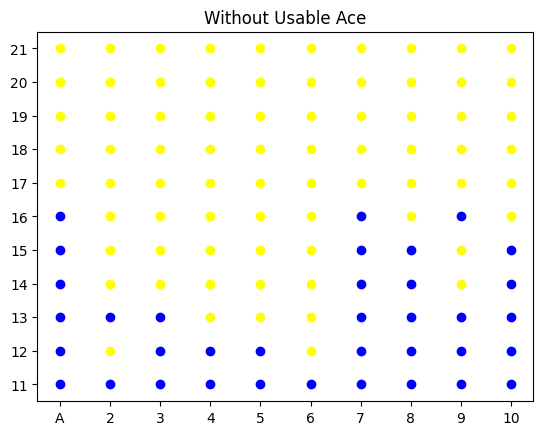

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Player(object):
    def __init__(self, currentSum, usableAce, dealersCard):
        self.currentSum = currentSum
        self.dealersCard = dealersCard
        self.usableAce = usableAce
        self.usingAce = self.usableAce

    def ReceiveCard(self, card):
        if self.usingAce and self.currentSum + card > 21:
            self.usingAce = False
            self.currentSum += card - 10
        else:
            self.currentSum += card

    def GetState(self):
        return (self.currentSum, self.usableAce, self.dealersCard)

    def GetValue(self):
        return self.currentSum

    def ShouldHit(self, policy):
        return policy[self.GetState()]

    def Bust(self):
        return self.GetValue() > 21

class Dealer(object):
    def __init__(self, cards):
        self.cards = cards

    def ReceiveCard(self, card):
        self.cards.append(card)

    def GetValue(self):
        currentSum = 0
        aceCount = 0

        for card in self.cards:
            if card == 1:
                aceCount += 1
            else:
                currentSum += card

        while aceCount > 0:
            aceCount -= 1
            currentSum += 11

            if currentSum > 21:
                aceCount += 1
                currentSum -= 11
                currentSum += aceCount
                break

        return currentSum

    def ShouldHit(self):
        if self.GetValue() >= 17:
            return False
        else:
            return True

    def Bust(self):
        return self.GetValue() > 21

class StateActionInfo(object):
    def __init__(self):
        self.stateActionPairs = [ ]
        self.stateActionMap = set()

    def AddPair(self, pair):
        if pair in self.stateActionMap:
            return

        self.stateActionPairs.append(pair)
        self.stateActionMap.add(pair)

def EvaluateAndImprovePolicy(qMap, policy, returns, stateActionPairs, reward):
    for pair in stateActionPairs:
        returns[pair] += 1
        qMap[pair] = qMap[pair] + ((reward - qMap[pair]) / returns[pair])

        state = pair[0]
        shouldHit = False

        if qMap[(state, True)] > qMap[(state, False)]:
            shouldHit = True

        policy[state] = shouldHit

def newCard():
    card = np.random.randint(1, 14)

    if card > 9:
        return 10
    else:
        return card

def PlayEpisode(qMap, policy, returns):
    playerSum = np.random.randint(11, 22)
    dealerOpenCard = np.random.randint(1, 11)
    usableAce = bool(np.random.randint(0, 2))

    player = Player(playerSum, usableAce, dealerOpenCard)
    dealer = Dealer([dealerOpenCard])

    stateActionInfo = StateActionInfo()
    hitAction = bool(np.random.randint(0, 2))
    stateActionInfo.AddPair((player.GetState(), hitAction))

    if hitAction:
        player.ReceiveCard(newCard())

        while not player.Bust() and player.ShouldHit(policy):
            stateActionInfo.AddPair((player.GetState(), True))
            player.ReceiveCard(newCard())

    if player.Bust():
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, -1)
        return

    stateActionInfo.AddPair((player.GetState(), False))
    dealer.ReceiveCard(newCard())

    while not dealer.Bust() and dealer.ShouldHit():
        dealer.cards.append(newCard())

    if dealer.Bust() or dealer.GetValue() < player.GetValue():
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, 1)
    elif dealer.GetValue() > player.GetValue():
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, -1)
    else:
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, 0)


qMap = { }
policy = { }
returns = { }

for playerSum in range(11, 22):
    for usableAce in range(2):
        for dealersCard in range(1, 11):
            playerState = (playerSum, bool(usableAce), dealersCard)
            qMap[(playerState, False)] = 0
            qMap[(playerState, True)] = 0
            returns[(playerState, False)] = 0
            returns[(playerState, True)] = 0

            if playerSum == 20 or playerSum == 21:
                policy[playerState] = False
            else:
                policy[playerState] = True

for i in range(100000):
    PlayEpisode(qMap, policy, returns)

x11 = [ ]
y11 = [ ]

x12 = [ ]
y12 = [ ]

x21 = [ ]
y21 = [ ]

x22 = [ ]
y22 = [ ]

for playerState in policy:
    if playerState[1]:
        if policy[playerState]:
            x11.append(playerState[2] - 1)
            y11.append(playerState[0] - 11)
        else:
            x12.append(playerState[2] - 1)
            y12.append(playerState[0] - 11)
    else:
        if policy[playerState]:
            x21.append(playerState[2] - 1)
            y21.append(playerState[0] - 11)
        else:
            x22.append(playerState[2] - 1)
            y22.append(playerState[0] - 11)

plt.figure(0)
plt.title('With Usable Ace')
plt.scatter(x11, y11, color='blue')
plt.scatter(x12, y12, color='yellow')
plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
plt.yticks(range(11), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

plt.figure(1)
plt.title('Without Usable Ace')
plt.scatter(x21, y21, color='blue')
plt.scatter(x22, y22, color='yellow')
plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
plt.yticks(range(11), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

plt.show()

In [3]:
import numpy as np

BOARD_ROWS = 3
BOARD_COLS = 4
WIN_STATE = (0, 3)      # 도착지 (보상 +1)
LOSE_STATE = (1, 3)     # 잘못된 곳 (보상 -1)
BLOCKED_STATE = (1, 1)  # 벽 (이동 불가)
START = (2, 0)          # 시작 위치
DETERMINISTIC = False   # 환경의 결정론적 여부 (False: 확률적)

# 상태 클래스 정의
class State:
    def __init__(self, state = START):
        self.state = state             # 현재 상태 (위치)
        self.isEnd = False             # 종단 상태 여부
        self.determine = DETERMINISTIC # 현재 이동이 결정론적인지 여부

    # 현재 상태에 따른 보상 반환
    def giveReward(self):
        if self.state == WIN_STATE:    # 제대로 도착하면
            return 1       # 보상을 줌
        elif self.state == LOSE_STATE: # 실패하면
            return -1      # -1
        else:
            return 0       # 그 외 상태는 보상 0

    # 현재 상태가 종단 상태인지 확인
    def isEndFunc(self):
        if (self.state == WIN_STATE) or (self.state == LOSE_STATE):  # 어딘가에 도착하면
            self.isEnd = True   # 끝

    # 확률적 환경에서 다음 행동을 선택 (주어진 행동 방향으로 80%, 다른 방향으로 10%씩)
    def _chooseActionProb(self, action):
        if action == "U":
            return np.random.choice(["U", "L", "R"], p = [0.8, 0.1, 0.1])
        if action == "D":
            return np.random.choice(["D", "L", "R"], p = [0.8, 0.1, 0.1])
        if action == "L":
            return np.random.choice(["L", "U", "D"], p = [0.8, 0.1, 0.1])
        if action == "R":
            return np.random.choice(["R", "U", "D"], p = [0.8, 0.1, 0.1])

    # 주어진 행동에 따른 다음 상태를 계산
    def nxtPosition(self, action):
        # determine이 True이면 결정론적 이동 (다음 상태는 고정)
        if self.determine:
            if action == "U":
                nxtState = (self.state[0] - 1, self.state[1])
            elif action == "D":
                nxtState = (self.state[0] + 1, self.state[1])
            elif action == "L":
                nxtState = (self.state[0], self.state[1] - 1)
            else:
                nxtState = (self.state[0], self.state[1] + 1)
            self.determine = False # 다음 이동은 확률적으로 설정
        # determine이 False이면 확률적 이동 (다음 상태는 확률에 따라 결정)
        else:
            action = self._chooseActionProb(action) # 확률에 따라 실제 행동 선택
            self.determine = True # 다음 이동은 결정론적으로 설정 (재귀 호출 시 사용)
            nxtState = self.nxtPosition(action) # 선택된 실제 행동으로 다음 상태 계산

        # 계산된 다음 상태의 유효성 확인 (격자 범위 내, 벽이 아님)
        if (nxtState[0] >= 0) and (nxtState[0] <= 2):
            if (nxtState[1] >= 0) and (nxtState[1] <= 3):
                if nxtState != BLOCKED_STATE:  # 다음 위치가 막힌 곳이 아니라면
                    return nxtState            # 그대로 반환
        # 유효하지 않은 상태인 경우 현재 상태 반환 (이동 실패)
        return self.state

# 에이전트 클래스 정의 (Q-Learning 알고리즘 구현)
class Agent:

    def __init__(self):
        self.states = [] # 방문한 상태-행동 쌍 리스트 (에피소드 기록)
        self.actions = ["U", "D", "L", "R"]  # 취할 수 있는 행동
        self.State = State()                 # 현재 상태 객체
        self.isEnd = self.State.isEnd        # 현재 에피소드 종료 여부
        self.lr = 0.2 # 학습률 (Learning Rate)
        self.decay_gamma = 0.9 # 할인율 (Discount Factor)

        self.Q_values = {}               # Q 값 딕셔너리 초기화 {(행, 열): {행동: Q값}}
        for i in range(BOARD_ROWS):      # 모든 행에 대해
            for j in range(BOARD_COLS):  # 모든 열에 대해
                self.Q_values[(i, j)] = {}  # 해당 위치에 대한 Q 값 딕셔너리 생성
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0 # 모든 행동에 대한 초기 Q 값 0

    # 현재 상태에서 Q 값을 기반으로 최적 행동 선택 (Greedy 정책)
    def chooseAction(self):
        max_nxt_reward = 0 # 최대 Q 값 초기화
        action = "" # 선택된 행동 초기화

        # 가능한 모든 행동에 대해 Q 값 확인
        for a in self.actions:
            current_position = self.State.state # 현재 에이전트 위치
            nxt_reward = self.Q_values[current_position][a] # 해당 행동의 Q 값
            # 현재까지의 최대 Q 값보다 크거나 같으면 업데이트 (같을 경우 첫 번째 행동 선택)
            if nxt_reward >= max_nxt_reward:
                action = a
                max_nxt_reward = nxt_reward
        return action # 최대 Q 값을 가지는 행동 반환

    # 주어진 행동을 수행하고 다음 상태 객체를 반환
    def takeAction(self, action):
        position = self.State.nxtPosition(action)   # 행동 후 상태 계산
        return State(state = position)              # 다음 상태 객체 생성 및 반환

    # 에피소드 종료 후 상태 및 기록 초기화
    def reset(self):
        self.states = [] # 방문 기록 초기화
        self.State = State() # 상태 객체 초기 위치로 초기화
        self.isEnd = self.State.isEnd # 종료 여부 초기화

    # 에피소드 수 만큼 게임을 플레이하고 Q-Learning 학습 수행
    def play(self, episodes = 10):
        i = 0 # 에피소드 카운터
        while i < episodes:
            # 에피소드가 종료된 경우 (목표 또는 실패 상태 도달)
            if self.State.isEnd:
                reward = self.State.giveReward()  # 최종 보상 획득
                # 종단 상태의 Q 값은 획득한 보상으로 설정
                for a in self.actions:
                    self.Q_values[self.State.state][a] = reward
                # 에피소드 동안 방문한 상태-행동 쌍을 역순으로 순회하며 Q 값 업데이트 (Off-Policy)
                for s in reversed(self.states):
                    current_q_value = self.Q_values[s[0]][s[1]] # 현재 상태-행동 쌍의 Q 값
                    reward = current_q_value + self.lr * (self.decay_gamma * reward - current_q_value)
                    self.Q_values[s[0]][s[1]] = round(reward, 3) # 업데이트된 Q 값 저장 (소수점 3자리 반올림)
                self.reset() # 상태 초기화
                i += 1 # 에피소드 카운트 증가
            # 에피소드가 진행 중인 경우
            else:
                action = self.chooseAction() # 현재 정책에 따라 행동 선택
                self.states.append([(self.State.state), action]) # 현재 상태-행동 쌍 기록
                self.State = self.takeAction(action) # 선택된 행동 수행 후 다음 상태로 이동
                self.State.isEndFunc() # 다음 상태가 종단 상태인지 확인
                self.isEnd = self.State.isEnd # 에피소드 종료 여부 업데이트

# 에이전트 객체 생성
ag = Agent()

# 1000번의 에피소드 플레이를 통해 학습 수행
ag.play(1000)
print("latest Q-values ... \n")
print(ag.Q_values) # 학습된 Q 값 출력

latest Q-values ... 

{(0, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0.633}, (0, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0.737}, (0, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0.864}, (0, 3): {'U': 1, 'D': 1, 'L': 1, 'R': 1}, (1, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0.147}, (1, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 2): {'U': 0, 'D': 0, 'L': 0.322, 'R': -0.18}, (1, 3): {'U': -1, 'D': -1, 'L': -1, 'R': -1}, (2, 0): {'U': 0, 'D': 0, 'L': 0.109, 'R': -0.001}, (2, 1): {'U': 0, 'D': 0, 'L': 0.088, 'R': -0.005}, (2, 2): {'U': 0, 'D': 0, 'L': 0.077, 'R': -0.029}, (2, 3): {'U': 0, 'D': 0, 'L': 0, 'R': -0.16}}
